Import libs and define some helpful functions

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import shap
from sklearn.model_selection import train_test_split, cross_val_score, cross_val_predict, StratifiedKFold
from sklearn.metrics import roc_auc_score
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import StandardScaler, OneHotEncoder, MinMaxScaler
from sklearn.pipeline import Pipeline
from sklearn.ensemble import RandomForestClassifier
from sklearn.naive_bayes import MultinomialNB
from catboost import CatBoostClassifier, Pool
from category_encoders import TargetEncoder
from datetime import datetime
from dateutil.relativedelta import relativedelta

In [2]:
def plot_dist_formated(col):
    plt.figure(figsize=(9,6))
    sns.distplot(data_1[col])
    plt.title("Distribution plot of '%s' variable" % col)
    plt.show()

In [3]:
def plot_boxplot_formated(col):
    plt.figure(figsize=(9,6))
    sns.boxplot(x=data_1[col], y=data_1.y)
    plt.title("Boxplot of '%s' variable" % col)
    plt.show()

In [4]:
def plot_countplot_formated(col, order=None):
    plt.figure(figsize=(15,6))
    sns.countplot(data_1[col], order=order)
    plt.title("Countplot of '%s' variable" % col)
    plt.show()

In [5]:
def plot_barplot_formated(col, order=None):
    plt.figure(figsize=(15,6))
    tmp_df = data_1[[col, 'y_num']].groupby([col], as_index=False).y_num.mean()
    sns.barplot(x=tmp_df[col], y=tmp_df.y_num, order=order)
    plt.title("Barplot of '%s' variable" % col)
    plt.ylabel('Subscription part')
    plt.show()

In [6]:
month_order = []
st_date = datetime(2019, 1, 1)
for i in range(12):
    month_order.append(st_date.strftime('%b').lower())
    st_date += relativedelta(months=1)

Read data

In [7]:
data_1 = pd.read_csv('bank-additional/bank-additional-full.csv', sep=';')

In [8]:
data_1.y.value_counts(True)

no     0.887346
yes    0.112654
Name: y, dtype: float64

In [9]:
data_1['y_num'] = data_1.y.apply(lambda x: 1 if x=='yes' else 0)

Our taget variable is a little bit unbalanced, but 11% is good.<br> First of all we need to check out data for consistence and outlier. Let's check every feature manually. We have only 20 of them so we can do it.<br>
To be honest, we can skeep this step with this dataset because it's already cleaned. But let pretend it's a real problem :)

In [10]:
print(data_1.isna().sum())

age               0
job               0
marital           0
education         0
default           0
housing           0
loan              0
contact           0
month             0
day_of_week       0
duration          0
campaign          0
pdays             0
previous          0
poutcome          0
emp.var.rate      0
cons.price.idx    0
cons.conf.idx     0
euribor3m         0
nr.employed       0
y                 0
y_num             0
dtype: int64


#### 1.Age

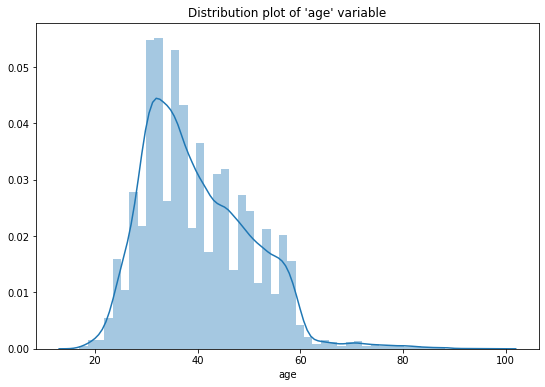

In [11]:
plot_dist_formated('age')

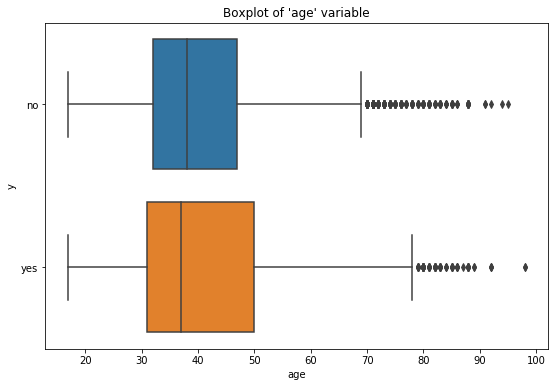

In [12]:
plot_boxplot_formated('age')

There are no outliers

#### 2. Job

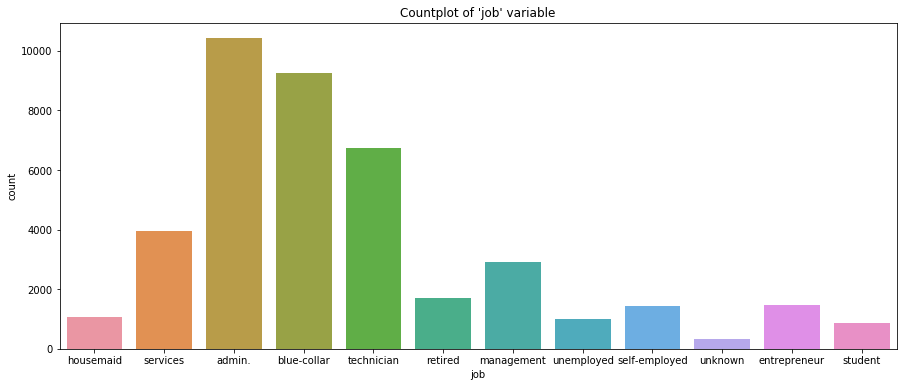

In [13]:
plot_countplot_formated('job')

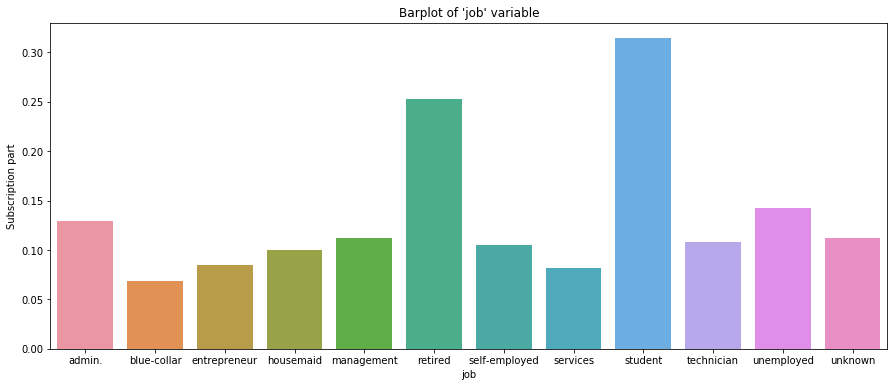

In [14]:
plot_barplot_formated('job')

It seems some columns have correlation with target variable.

#### 3. Marital

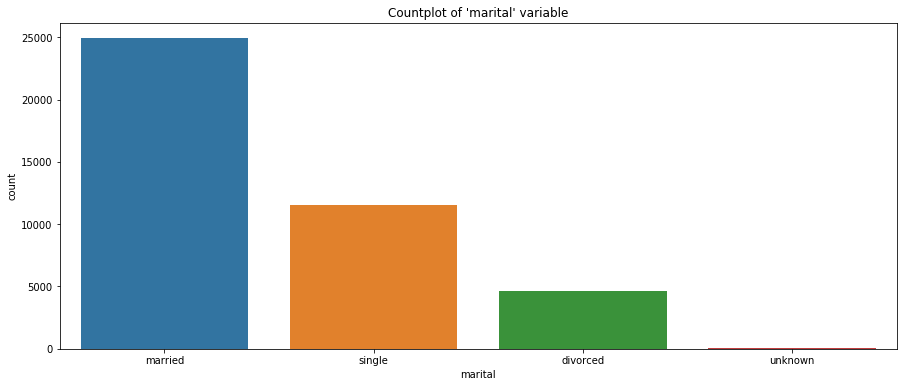

In [15]:
plot_countplot_formated('marital')

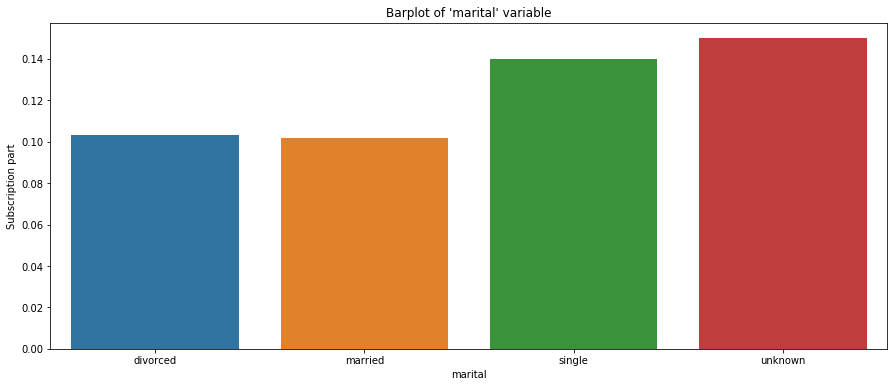

In [16]:
plot_barplot_formated('marital')

Some marital statuses may also have correlation with target.

#### 4. Education

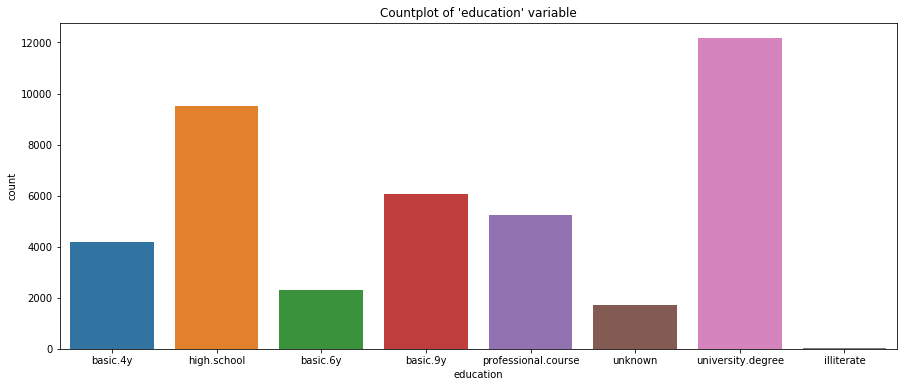

In [17]:
plot_countplot_formated('education')

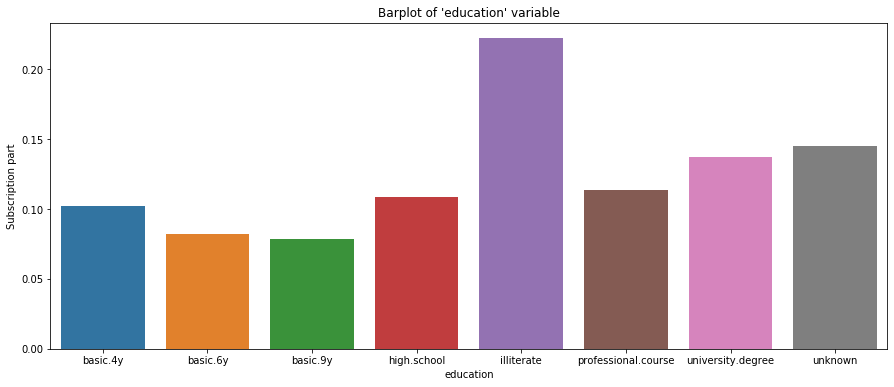

In [18]:
plot_barplot_formated('education')

#### 5. Default

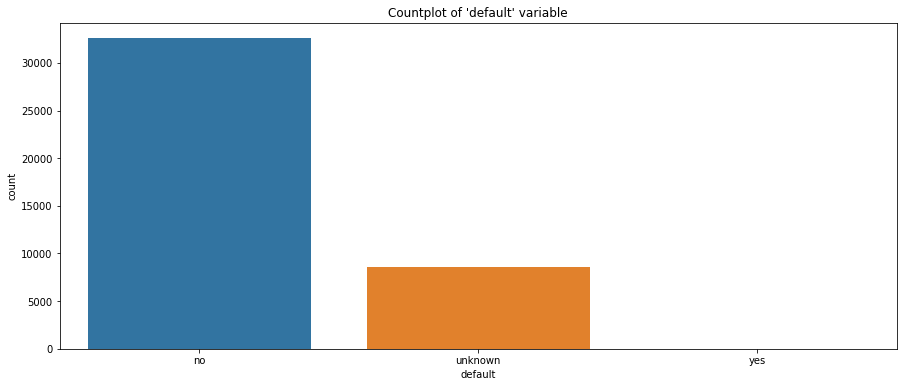

In [19]:
plot_countplot_formated('default')

In [20]:
data_1.default.value_counts()

no         32588
unknown     8597
yes            3
Name: default, dtype: int64

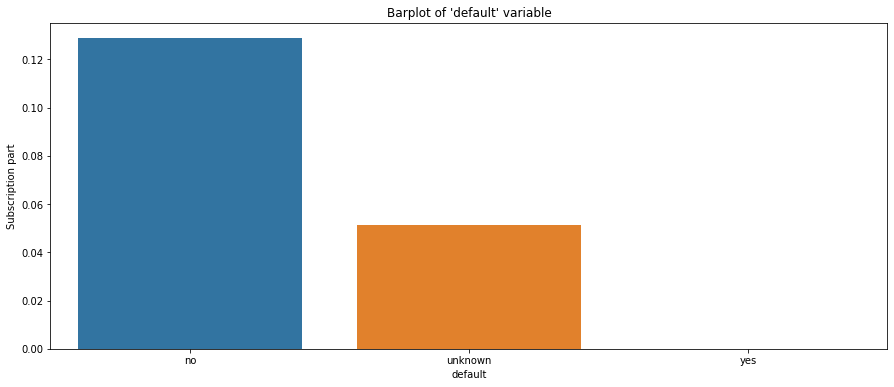

In [21]:
plot_barplot_formated('default')

The amount of people with default is very small. But there is a big difference in deposit acceptance rate between 'no' and 'unknown'. The possible reason is people with default might get in unknown group.

#### 6. Housing

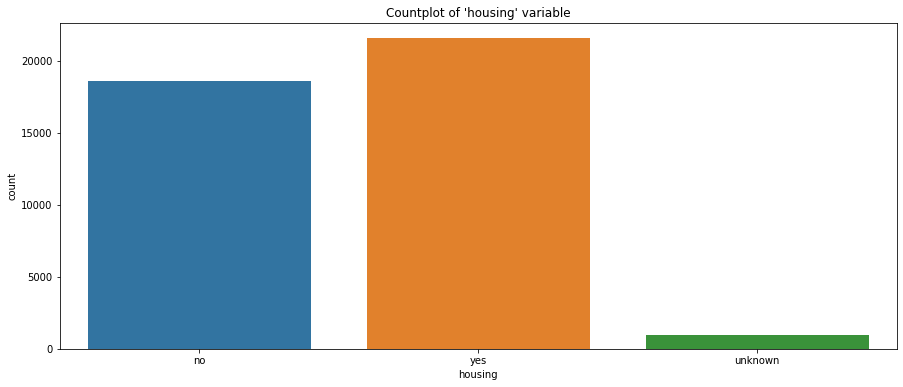

In [22]:
plot_countplot_formated('housing')

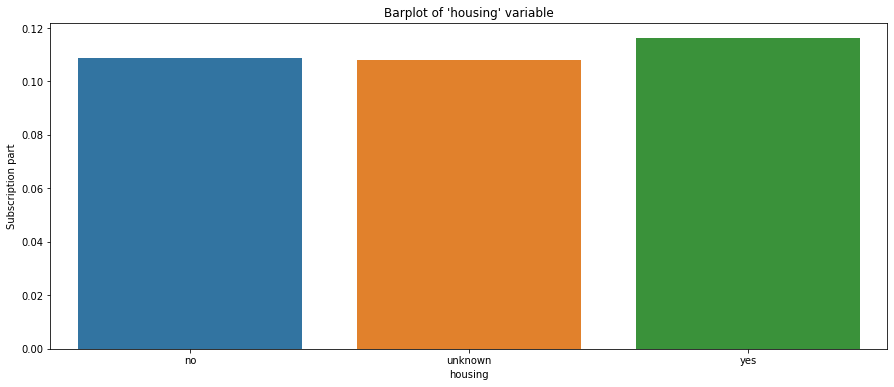

In [23]:
plot_barplot_formated('housing')

Nothing interesting

#### 7. Loan

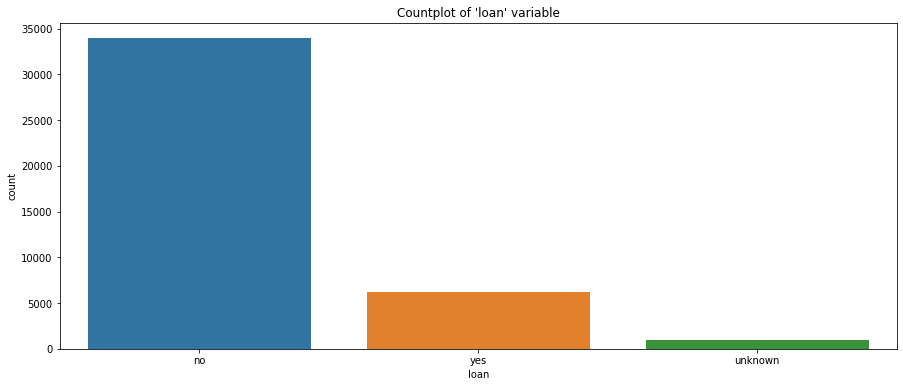

In [24]:
plot_countplot_formated('loan')

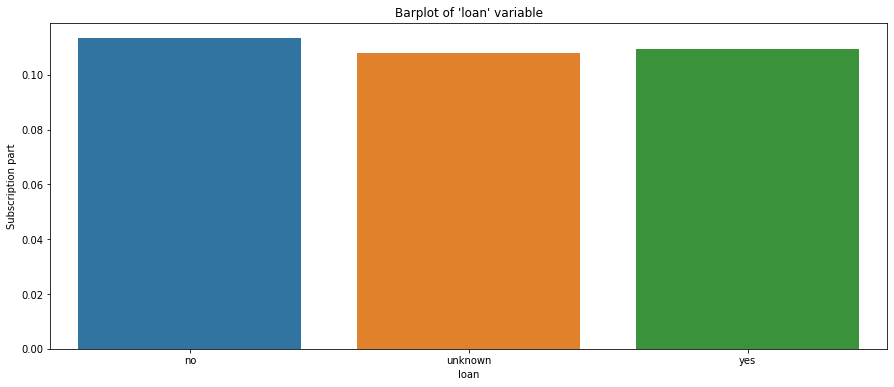

In [25]:
plot_barplot_formated('loan')

#### 8. Contact 

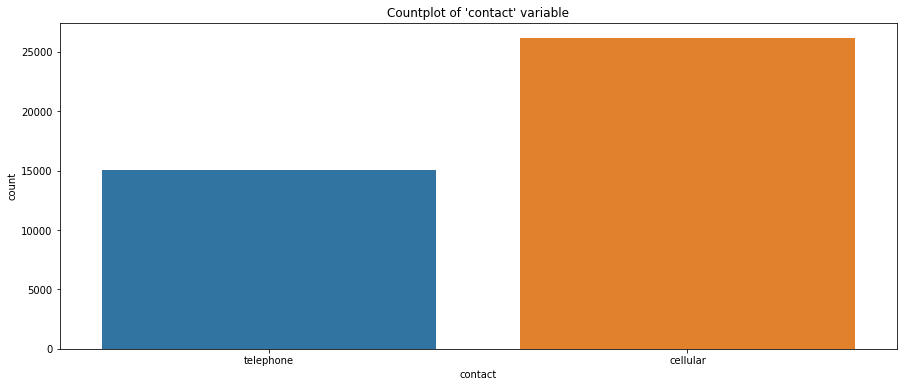

In [26]:
plot_countplot_formated('contact')

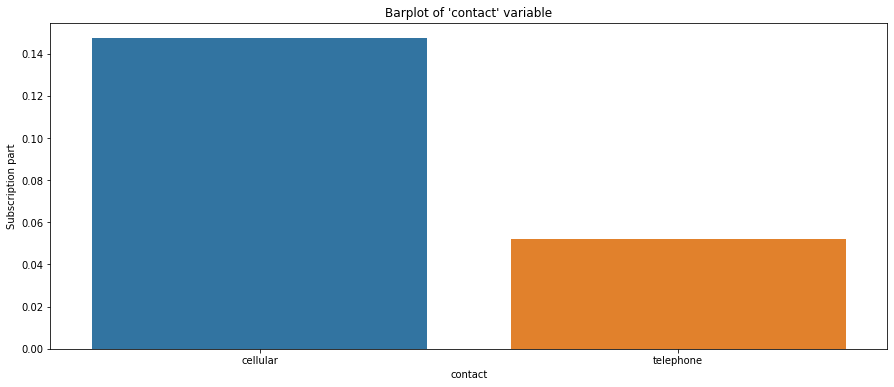

In [27]:
plot_barplot_formated('contact')

Looks like a useful feature. The correlction may be connected with wealth of subscribers

#### 9. Month

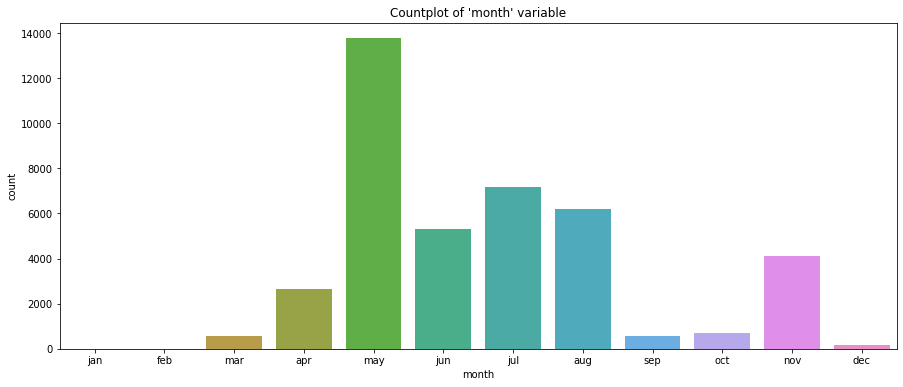

In [28]:
plot_countplot_formated('month', order=month_order)

In [29]:
data_1.month.value_counts()

may    13769
jul     7174
aug     6178
jun     5318
nov     4101
apr     2632
oct      718
sep      570
mar      546
dec      182
Name: month, dtype: int64

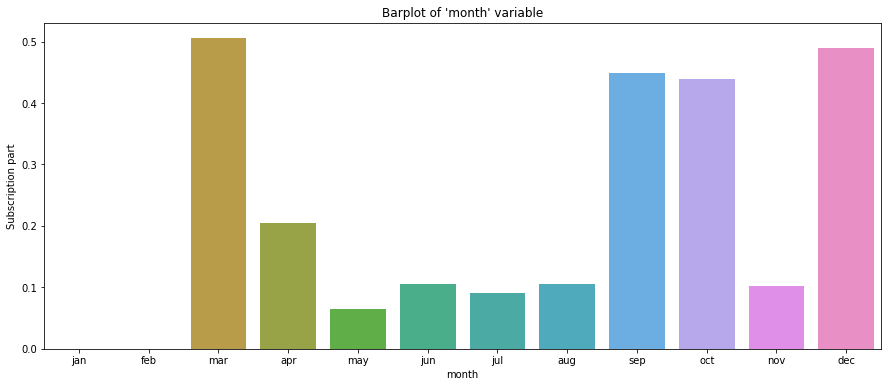

In [30]:
plot_barplot_formated('month', order=month_order)

The distribution of months is very strange. It looks like problems with data collection

#### 10. Day of week

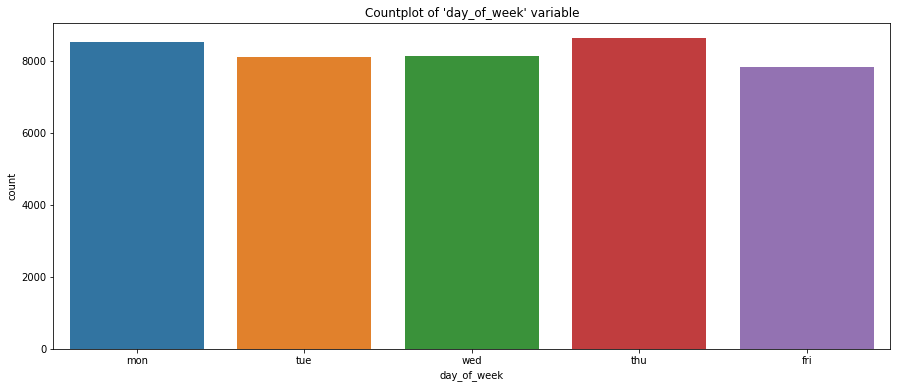

In [31]:
plot_countplot_formated('day_of_week')

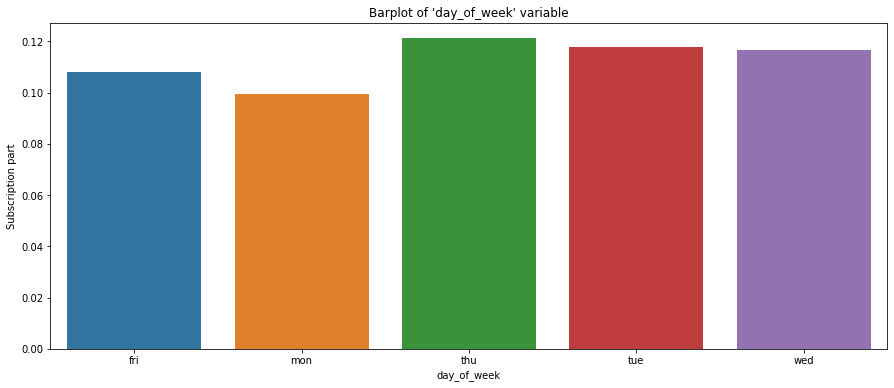

In [32]:
plot_barplot_formated('day_of_week')

All is OK

#### 11. Duration

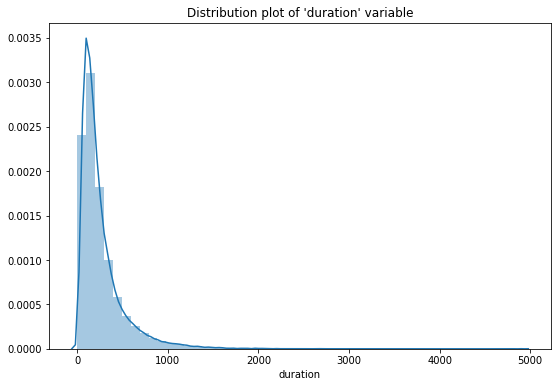

In [33]:
plot_dist_formated('duration')

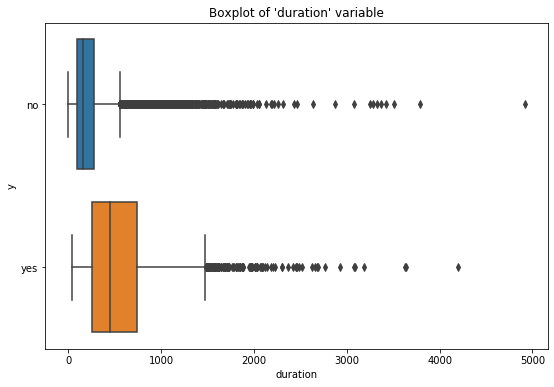

In [34]:
plot_boxplot_formated('duration')

We are not able to use this feature for prediction, because we don't know about a call duration before a call.

#### 12. Campaign 

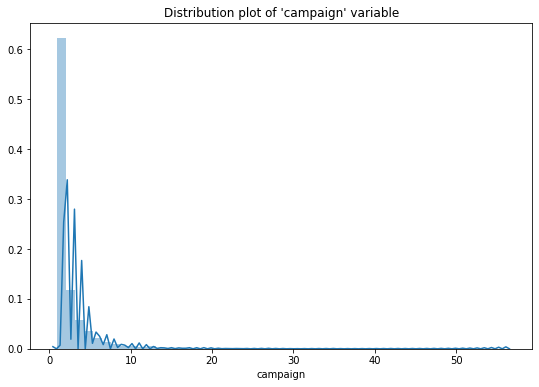

In [35]:
plot_dist_formated('campaign')

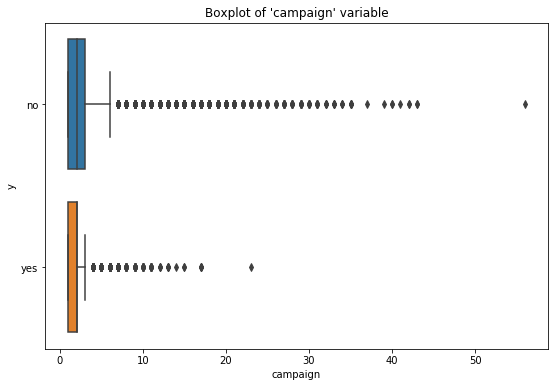

In [36]:
plot_boxplot_formated('campaign')

All is ok

#### 13. Pdays

In [37]:
data_1.pdays.value_counts()

999    39673
3        439
6        412
4        118
9         64
2         61
7         60
12        58
10        52
5         46
13        36
11        28
1         26
15        24
14        20
8         18
0         15
16        11
17         8
18         7
19         3
22         3
21         2
26         1
20         1
25         1
27         1
Name: pdays, dtype: int64

pdays=999 means that it will be the first contact with subscriber. We can create new feature 'is_first_contract' to help model to separate such clients

In [38]:
data_1['is_first_contact'] = data_1.pdays.apply(lambda x: 1 if x==999 else 0)

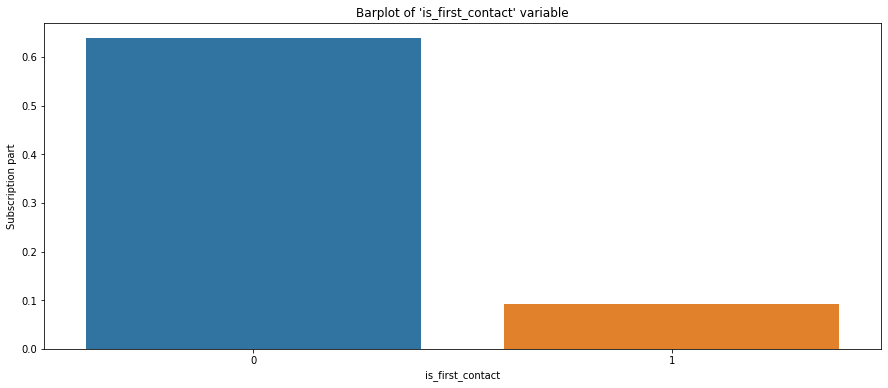

In [39]:
plot_barplot_formated('is_first_contact')

#### 14. Previous

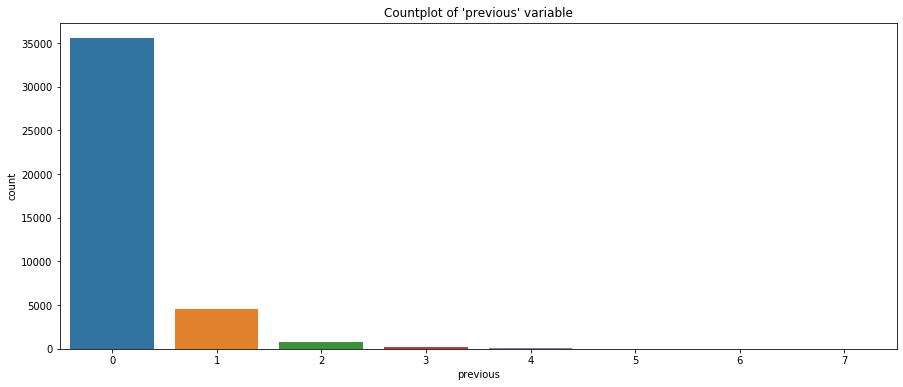

In [40]:
plot_countplot_formated('previous')

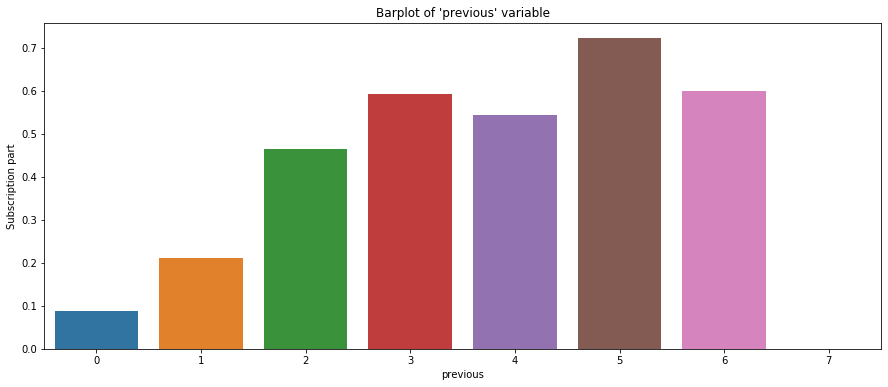

In [41]:
plot_barplot_formated('previous')

It looks like clients don't like to accept offers from the first call.

#### 15. Poutcome

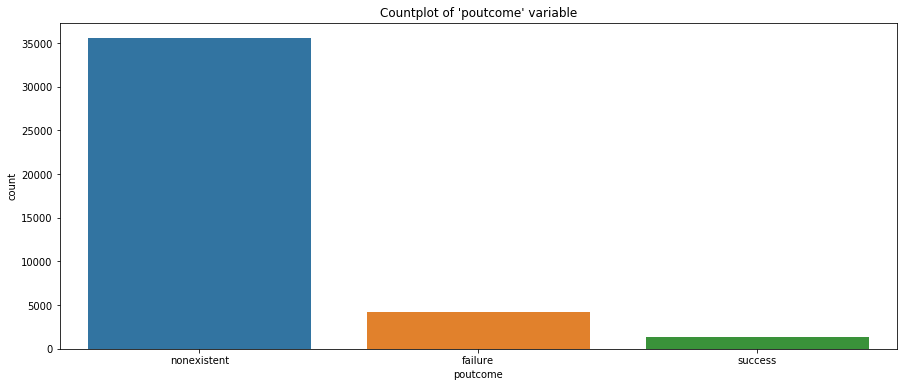

In [42]:
plot_countplot_formated('poutcome')

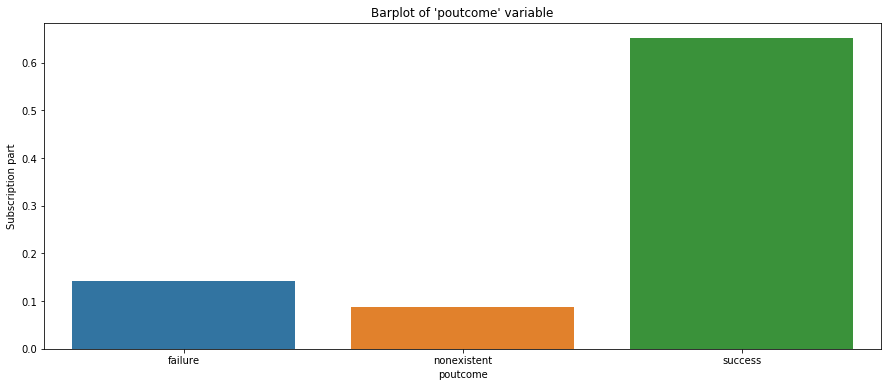

In [43]:
plot_barplot_formated('poutcome')

It's good when the client accepted an offer in the past

#### 16. emp. var. rate

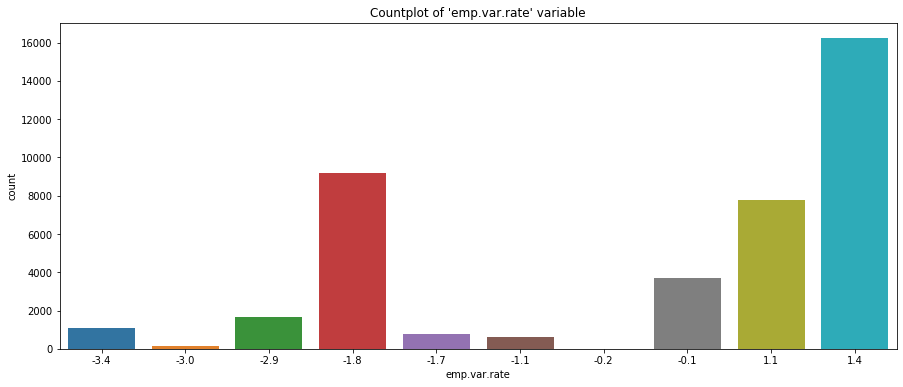

In [44]:
plot_countplot_formated('emp.var.rate')

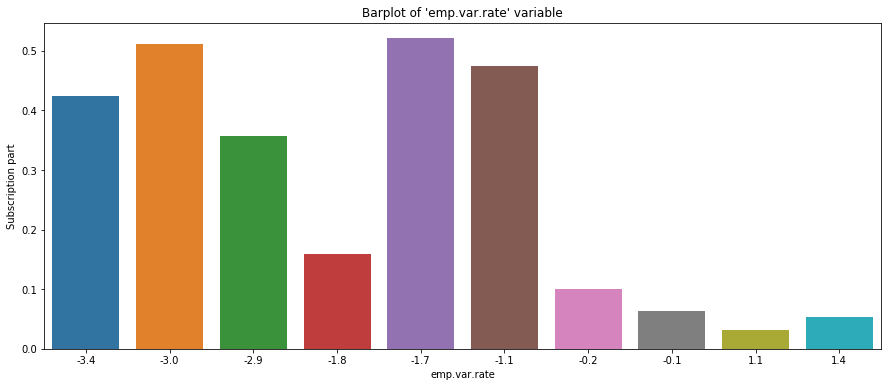

In [45]:
plot_barplot_formated('emp.var.rate')

#### 17. Cons.price.idx

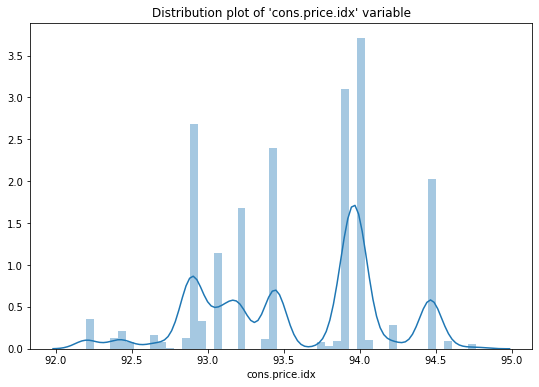

In [46]:
plot_dist_formated('cons.price.idx')

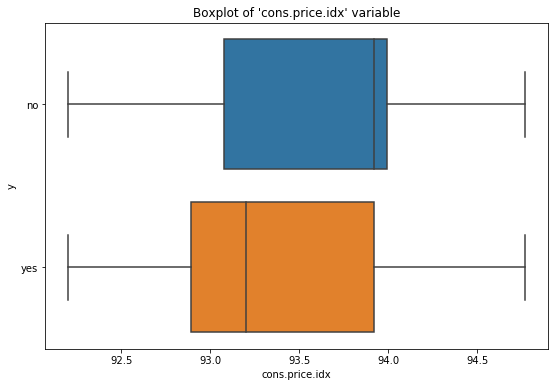

In [47]:
plot_boxplot_formated('cons.price.idx')

Look's like an important feature

#### 18. Cons.conf.idx

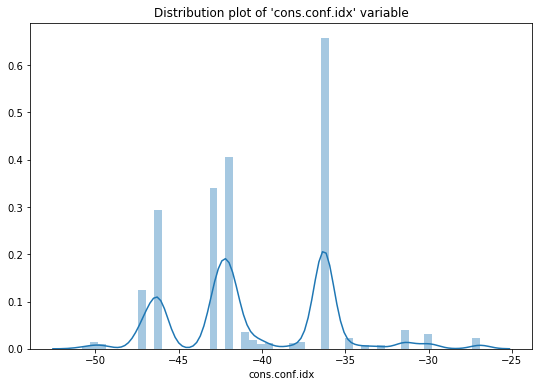

In [48]:
plot_dist_formated('cons.conf.idx')

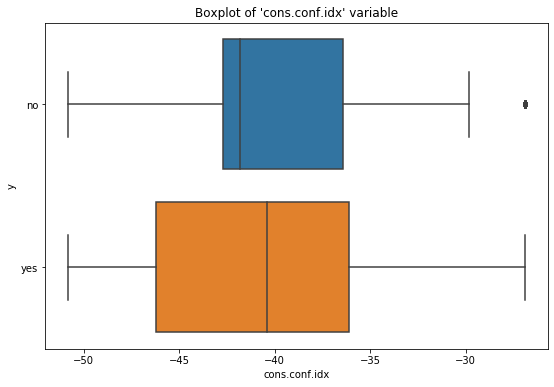

In [49]:
plot_boxplot_formated('cons.conf.idx')

#### 19. Euribor3m

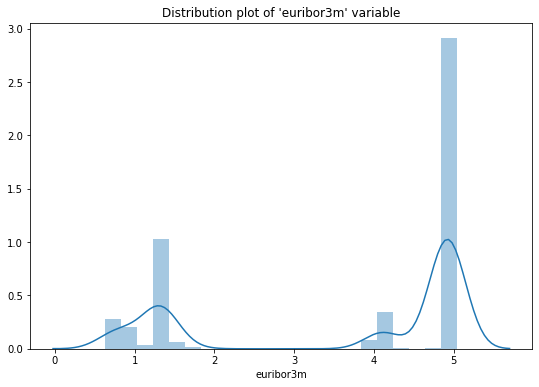

In [50]:
plot_dist_formated('euribor3m')

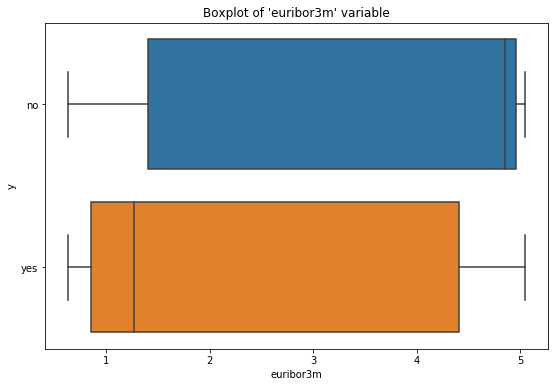

In [51]:
plot_boxplot_formated('euribor3m')

#### 20. nr.employed

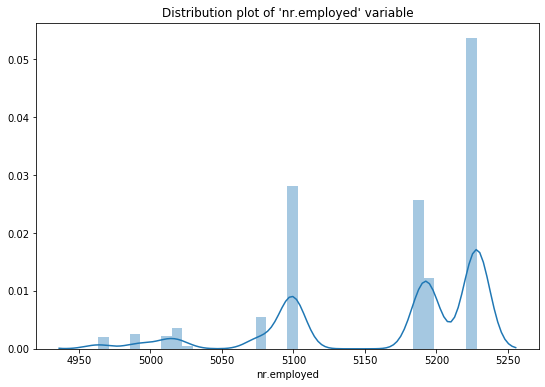

In [52]:
plot_dist_formated('nr.employed')

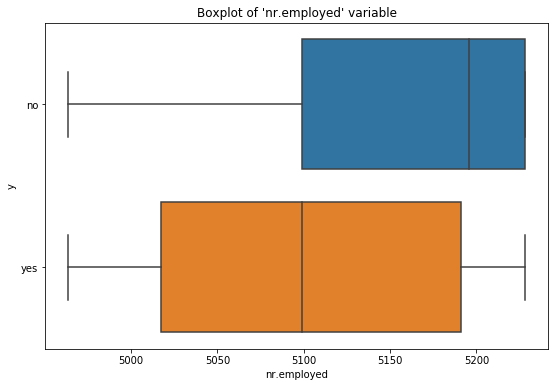

In [53]:
plot_boxplot_formated('nr.employed')

## Modelling

I'm absolutely sure that best accuracy will be achieved by using boosting. But let compare different algorithms. I will use roc-auc as main metric for comparison.

In [54]:
CAT_FEATURES = ['job', 'marital', 'education', 'default', 'housing', 'loan',
       'contact', 'month', 'day_of_week', 'poutcome']

In [55]:
x = data_1.drop(['duration', 'y', 'y_num'], axis=1)
y = data_1[['y_num']]

In [56]:
def one_hot_transform(x, features):
    for feature in features:
        oh = OneHotEncoder()
        feature_encoded = oh.fit_transform(x[[feature]]).toarray()
        for i, cat in enumerate(oh.categories_[0]):
            x[feature+'_'+cat]=feature_encoded[:,i]
        x.drop(feature, axis=1, inplace=True)
    return x

In [57]:
x_with_oh = one_hot_transform(x.copy(), CAT_FEATURES)

In [58]:
sk = StratifiedKFold(n_splits=5, shuffle=True)
def custom_cross_val(model, x, y):
    scores = []
    for train_ind, test_ind in sk.split(x, y):
        model.fit(x.iloc[train_ind], y.iloc[train_ind])
        scores.append(roc_auc_score(y.iloc[test_ind], model.predict_proba(x.iloc[test_ind])[:,1]))
    return scores

#### Logistic regression with target encoder

In [59]:
lr_target_pipeline = Pipeline([('cat_enc', TargetEncoder()),
                           ('scaler', StandardScaler()),
                          ('model', LogisticRegression(max_iter=1000))])

In [60]:
np.mean(custom_cross_val(lr_target_pipeline, x, y.y_num))

0.7877059806093275

#### Logistic regression with one hot encoder

In [61]:
lr_oh_pipeline = Pipeline([('scaler', StandardScaler()),
                          ('model', LogisticRegression(max_iter=1000))])

In [62]:
np.mean(custom_cross_val(lr_oh_pipeline, x_with_oh, y.y_num))

0.7916393530730825

#### Random forest with target encoder

In [63]:
rf_target_pipeline = Pipeline([('cat_enc', TargetEncoder()),
                          ('model', RandomForestClassifier(n_estimators=100))])

In [64]:
np.mean(custom_cross_val(rf_target_pipeline, x, y.y_num))

0.7736045190420422

#### Random forest with one hot encoder

In [65]:
rf_oh_pipeline = Pipeline([('model', RandomForestClassifier(n_estimators=100))])

In [66]:
np.mean(custom_cross_val(rf_oh_pipeline, x_with_oh, y.y_num))

0.7725810692190516

#### Multinomial NB with one hot encoder

In [67]:
nb_oh_pipeline = Pipeline([('scaler', MinMaxScaler()),
                          ('model', MultinomialNB())])

In [68]:
np.mean(custom_cross_val(nb_oh_pipeline, x_with_oh, y.y_num))

0.7736737423718238

#### Multinomial NB with target encoder

In [69]:
nb_target_pipeline = Pipeline([('cat_enc', TargetEncoder()),
                               ('scaler', MinMaxScaler()),
                          ('model', MultinomialNB())])

In [70]:
np.mean(custom_cross_val(nb_target_pipeline, x, y.y_num))

0.7759639151585109

#### Catboost encoder

In [71]:
model = CatBoostClassifier(cat_features=CAT_FEATURES, verbose=False)

In [72]:
np.mean(custom_cross_val(model, x, y.y_num))

0.8043256323324677

Catboost model has the best score. In real problem we can try to finetune all models, but I will skip it because it requires a lot of time.<br> I will use grid search to find better params only for catboost model.

In [73]:
model = CatBoostClassifier(cat_features=CAT_FEATURES, verbose=False, iterations=2000, early_stopping_rounds=200)

In [74]:
res = model.grid_search({'depth':np.arange(2,10),
                  'l2_leaf_reg':[0.3, 0.5, 0.75, 1, 1.5, 2, 3, 4, 5]}, x, y.y_num, cv=5, plot=True)

MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))


bestTest = 0.2748569585
bestIteration = 1999

0:	loss: 0.2748570	best: 0.2748570 (0)	total: 22.8s	remaining: 26m 57s

bestTest = 0.2745033638
bestIteration = 1999

1:	loss: 0.2745034	best: 0.2745034 (1)	total: 45.9s	remaining: 26m 48s

bestTest = 0.2743652614
bestIteration = 1988

2:	loss: 0.2743653	best: 0.2743653 (2)	total: 1m 5s	remaining: 25m 14s

bestTest = 0.2745012763
bestIteration = 1999

3:	loss: 0.2745013	best: 0.2743653 (2)	total: 1m 25s	remaining: 24m 13s

bestTest = 0.2744500504
bestIteration = 1998

4:	loss: 0.2744501	best: 0.2743653 (2)	total: 1m 45s	remaining: 23m 34s

bestTest = 0.274518574
bestIteration = 1999

5:	loss: 0.2745186	best: 0.2743653 (2)	total: 2m 6s	remaining: 23m 6s

bestTest = 0.2747605495
bestIteration = 1995

6:	loss: 0.2747605	best: 0.2743653 (2)	total: 2m 26s	remaining: 22m 39s

bestTest = 0.2746443325
bestIteration = 1999

7:	loss: 0.2746443	best: 0.2743653 (2)	total: 2m 47s	remaining: 22m 16s

bestTest = 0.2745447417
bestIteration = 1998

8:	loss

Stopped by overfitting detector  (200 iterations wait)

bestTest = 0.2735983774
bestIteration = 507

50:	loss: 0.2735984	best: 0.2727862 (34)	total: 18m 45s	remaining: 7m 43s
Stopped by overfitting detector  (200 iterations wait)

bestTest = 0.2730580612
bestIteration = 568

51:	loss: 0.2730581	best: 0.2727862 (34)	total: 19m 9s	remaining: 7m 22s
Stopped by overfitting detector  (200 iterations wait)

bestTest = 0.2732981244
bestIteration = 534

52:	loss: 0.2732981	best: 0.2727862 (34)	total: 19m 34s	remaining: 7m 1s
Stopped by overfitting detector  (200 iterations wait)

bestTest = 0.2735253352
bestIteration = 593

53:	loss: 0.2735253	best: 0.2727862 (34)	total: 19m 59s	remaining: 6m 39s
Stopped by overfitting detector  (200 iterations wait)

bestTest = 0.2744635203
bestIteration = 607

54:	loss: 0.2744635	best: 0.2727862 (34)	total: 20m 33s	remaining: 6m 21s
Stopped by overfitting detector  (200 iterations wait)

bestTest = 0.2747577571
bestIteration = 193

55:	loss: 0.2747578	best: 

In [77]:
res['params']

{'depth': 5, 'l2_leaf_reg': 4}

In [78]:
np.mean(custom_cross_val(CatBoostClassifier(cat_features=CAT_FEATURES, verbose=False, depth=5, l2_leaf_reg=4, iterations=2000), x, y.y_num))

0.8050589631557191

The best roc-auc score is <b>0.8051</b>

Let's take a look at feature importance

In [105]:
model = CatBoostClassifier(cat_features=CAT_FEATURES, verbose=False, depth=5, l2_leaf_reg=4, iterations=2000).fit(x, y.y_num)

In [107]:
shap.initjs()

In [108]:
shap_values = model.get_feature_importance(Pool(x, y.y_num, cat_features=CAT_FEATURES), type='ShapValues')

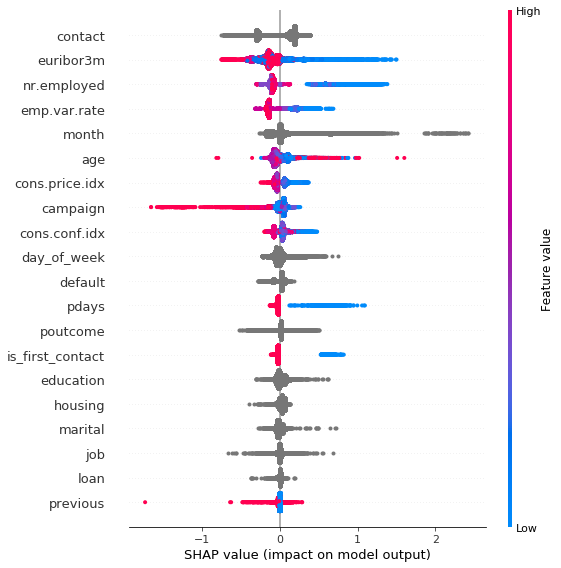

In [109]:
shap.summary_plot(shap_values[:,:-1], x)

<h3>Conclusions</h3>

First of all I've built a good model able to indentify potentional clients for marketing campaigns.
The most important features are 'contact' and "social and economic context attributes" - it sounds reasonable. But there're some reasons why I will think twice before using such model:<br>
1) I don't like that 'month' is one of the most important features and I think it needs to be investigated. There's no problem if it caused by seasonal events (like people do a deposit every september in order to save money for Chirstmas gifts). But if it caused by singular event we will have a problem, because in the next year model will have very poor accuracy in that month.<br>
2) A lot of features in this dataset depends on time, so we need to sort all rows by time to perfom 'nested cross-validation' (train data must be earlier than validation/test data). We can't do it because data are aggregated for some years and there's no a column with 'year' speficied.<br>
So, if you were a real customer I would ask you to provide me with column 'year', because it can solve problems above.